In [1]:
from typing import TypedDict, Annotated, Sequence
import operator
import math

from langgraph.graph import StateGraph, END

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool


In [2]:
class TaskManagerState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    
    tasks: list[dict]
    
    # task_history: list[str]
    

In [3]:
counter=0

In [4]:
@tool
def add_task(title: str, priority: str ='medium') -> str:
    """ add a new task to the list"""
    global counter
    counter += 1
    print(f"Task {title} added with priority {priority}")
    return {'id': counter,
            'title':title,
            'priority':priority,
            'status':'pending'}
 

@tool
def remove_task(task_id: int) -> str:
    """ deletes the task based on the task_id"""
    print(f"Task {task_id} removed successfully")
    return {'id':task_id}


@tool
def update_task(task_id: int, title: str = None, priority: str = None) -> str:
    """Update task title or priority"""
    print(f"Task {task_id} updated successfully")
    return {"id": task_id, "title": title, "priority": priority}


tools = [add_task, remove_task,update_task]
    
    

In [5]:
from dotenv import load_dotenv
load_dotenv()

# Method 4: Pass api_key directly to ChatOpenAI (not recommended)
# llm = ChatOpenAI(model="gpt-4", temperature=0, api_key="your-api-key-here")
model_name= "gpt-4.1-mini"
# Create the base LLM (temperature=0 for deterministic responses)
llm = ChatOpenAI(model=model_name, temperature=0)

# Bind the calculation tools to the LLM
# This enables the model to call these tools when needed
llm_with_tools = llm.bind_tools(tools)

print("✓ Language model initialized with tools")
print(f"  Model: {model_name}")
print(f"  Available tools: {len(tools)}")

✓ Language model initialized with tools
  Model: gpt-4.1-mini
  Available tools: 3


In [6]:
def call_model(state: TaskManagerState) -> dict:
    """
    This node calls the LLM with the current conversation history.
    The LLM will either:
    - Call one or more tools (for calculations)
    - Respond with a final answer (no more tools needed)
    """
    messages = state["messages"]
    print(f"""Step1: Run the call_model function with message as {state["messages"]}""")
    
    # Invoke the LLM with tools
    response = llm_with_tools.invoke(messages)
    print(f"Response from 'llm_with_tools.invoke(messages)' command is {response}\n")
    # Return the response as a new message to be added to state
    return {"messages": [response]}


def call_tools(state: TaskManagerState) -> dict:
    """This node executes all tool calls from the last agent message.
        It runs the actual task tools and returns the results.
    """
    
    messages = state["messages"]
    last_messages = messages[-1]
    
    tool_calls = last_messages.tool_calls
    
    tool_map = {tool.name:tool for tool in tools}
    
    tool_messages=[]
    tasks = state.get('tasks',[])
    
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]
    
        selected_tool = tool_map[tool_name]
    
        try:
            result = selected_tool.invoke(tool_args)
        #    task_record = f"{tool_name}({', '.join(map(str, tool_args.values()))}) = {result}"
            if tool_name=='add_task':
               tasks.append(result)
               
            if tool_name=='remove_task' and len(tasks)>0:
               tasks = [task for task in tasks if task.get('id') != result['id']]
            
            if tool_name == 'update_task' and len(tasks)>0:
                task_to_be_updated = [task for task in tasks if task.get('id')==result['id']]
                matching_task = task_to_be_updated[0]
                if matching_task['title'] is not None:
                    matching_task['title'] = result['title']
                if matching_task['priority'] is not None:
                    matching_task['priority'] = result['priority']
                
                tasks = [task if task.get('id') != result['id'] else matching_task for task in tasks]
                
                # remaining_tasks = [task for task in tasks if task.get('id')!=result['id']]
                # task_to_be_updated['title']=result['title']
                # task_to_be_updated['priority']=result['priority']
                # remaining_tasks.append(task_to_be_updated)
                # tasks = remaining_tasks
                # # {"id": task_id, "title": title, "priority": priority}
                
            tool_messages.append(
               ToolMessage(
                   content=str(result),
                   tool_call_id = tool_id,
                   name=tool_name))
           
        except Exception as e:
            # Handle any errors during tool execution
               tool_messages.append(
                ToolMessage(
                content=f"Error: {str(e)}",
                tool_call_id=tool_id,
                name=tool_name
            )
        )
        
    return {
        "messages": tool_messages,
        "tasks": tasks
    }
    
    
def should_continue(state: TaskManagerState) -> str:
    """
    This function checks if the agent wants to use more tools.
    If there are tool calls in the last message, we continue to the tools node.
    Otherwise, we end the execution.
    """
    
    print("Now, we have entered into should_continue function. After call_model and before should_contninue, langGraph appends the state['mesage']  based the state['message] + response from lllm_with_tools.invoke(messages)")
    
    messages = state["messages"]
    last_message = messages[-1]
    
    # Check if there are any tool calls in the last message
    if not hasattr(last_message, "tool_calls") or not last_message.tool_calls:
        print("Step2: Run the should_continue function -- END")
        print(f"In should_continue, message from state['message] is {messages}\n")
        return "end"  # No more tools to call, we're done
    
    print("Step2: Run the should_continue function -- CONTINUE")
    print(f"In should_continue, message from state['message] is {messages}\n")
    
    return "continue"  # More tools to execute

In [7]:
# Function to create and compile the task manager graph
def create_taskmanager_graph():
    """
    Build the LangGraph calculator agent.
    Returns a compiled graph ready for execution.
    """
    
    # Initialize the StateGraph with our state schema
    workflow = StateGraph(TaskManagerState)
    
    # Add nodes to the graph
    # "agent" node: calls the LLM to make decisions
    workflow.add_node("TaskAgent", call_model)
    
    # "tools" node: executes the calculation tools
    workflow.add_node("TaskTools", call_tools)
    
    # Set the entry point (where execution starts)
    workflow.set_entry_point("TaskAgent")
    
    # Add conditional edges from agent node
    # Based on should_continue(), either go to tools or END
    workflow.add_conditional_edges(
        "TaskAgent",  # From the agent node
        should_continue,  # Use this function to decide
        {
            "continue": "TaskTools",  # If continue, go to tools node
            "end": END  # If end, finish execution
        }
    )
    
    # Add edge from tools back to agent
    # This creates the loop: agent → tools → agent → ...
    workflow.add_edge("TaskTools", "TaskAgent")
    
    # Compile the graph into an executable form
    return workflow.compile()


# Create the calculator graph
taskmanager_graph = create_taskmanager_graph()

print("✓ Calculator graph created and compiled!")
print("\nGraph structure:")
print("  START → agent → [conditional] → tools → agent → ... → END")

✓ Calculator graph created and compiled!

Graph structure:
  START → agent → [conditional] → tools → agent → ... → END


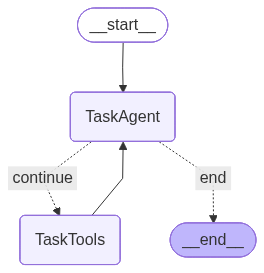

In [8]:
taskmanager_graph

In [9]:
# Helper function to run the calculator agent with a question
def run_calculator_agent(question: str, verbose: bool = True):
    """
    Run the calculator agent with a user question.
    
    Args:
        question: The user's calculation question in natural language
        verbose: If True, print detailed output
    
    Returns:
        The final state containing all messages and calculation history
    """
    
    # Initialize the state with the user's question
    initial_state = {
        "messages": [HumanMessage(content=question)],
        "tasks": []
    }
    
    if verbose:
        print(f"\n{'='*70}")
        print(f"Question: {question}")
        print(f"{'='*70}\n")
    
    # Invoke the graph with the initial state
    # The graph will run until it reaches END
    result = taskmanager_graph.invoke(initial_state)
    
    if verbose:
        # Display all calculation steps
        if result.get("tasks"):
            print("tasks Steps:")
            for i, calc in enumerate(result["tasks"], 1):
                print(f"   {i}. {calc}")
            print()
        
        # Display the final answer from the agent
        final_message = result["messages"][-1]
        print(f"Final Answer: {final_message.content}\n")
    
    return result


print("✓ Helper function ready to use")

✓ Helper function ready to use


In [10]:
myresult = run_calculator_agent("""add task to bring milk as high priority, then add task to clean the house as medium priority. 
                                Now, delete task 1 and update priority of task 2 to very high""")


Question: add task to bring milk as high priority, then add task to clean the house as medium priority. 
                                Now, delete task 1 and update priority of task 2 to very high

Step1: Run the call_model function with message as [HumanMessage(content='add task to bring milk as high priority, then add task to clean the house as medium priority. \n                                Now, delete task 1 and update priority of task 2 to very high', additional_kwargs={}, response_metadata={})]


Response from 'llm_with_tools.invoke(messages)' command is content='' additional_kwargs={'tool_calls': [{'id': 'call_PA3Ro2oFSfeK4c5QvxDHPQDs', 'function': {'arguments': '{"title": "bring milk", "priority": "high"}', 'name': 'add_task'}, 'type': 'function'}, {'id': 'call_lcWOqF5LVUUk4igldM4wRhYM', 'function': {'arguments': '{"title": "clean the house", "priority": "medium"}', 'name': 'add_task'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 162, 'total_tokens': 217, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--ce4f24f9-b563-454e-b7a7-4f04b263f23b-0' tool_calls=[{'name': 'add_task', 'args': {'title': 'bring milk', 'priority

In [11]:
myresult

{'messages': [HumanMessage(content='add task to bring milk as high priority, then add task to clean the house as medium priority. \n                                Now, delete task 1 and update priority of task 2 to very high', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_PA3Ro2oFSfeK4c5QvxDHPQDs', 'function': {'arguments': '{"title": "bring milk", "priority": "high"}', 'name': 'add_task'}, 'type': 'function'}, {'id': 'call_lcWOqF5LVUUk4igldM4wRhYM', 'function': {'arguments': '{"title": "clean the house", "priority": "medium"}', 'name': 'add_task'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 162, 'total_tokens': 217, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-m

In [12]:
myresult.keys()

dict_keys(['messages', 'tasks'])